In [1]:
from linkage_utils import (
    batch_random_generator,
    sort_mech,
    solve_rev_vectorized_batch_wds,
    batch_get_mat,
    solve_mechanism,
    get_oriented,
    get_oriented_both,
    batch_get_oriented_both,
)
import matplotlib.pyplot as plt
import torch
import numpy as np
import wandb

In [4]:
def batch_generate_mechs(config):
    BATCH_SIZE = config["BATCH_SIZE"]
    NODE_COUNT = config["NODE_COUNT"]
    TIMESTEPS = config["TIMESTEPS"]
    SPATIAL_DIMS = config["SPATIAL_DIMS"]

    mechanisms = batch_random_generator(
        BATCH_SIZE,
        N_min=NODE_COUNT,
        N_max=NODE_COUNT,
        show_progress=True,
        strategy="rand",
    )
    # For clarity, convert the mechanisms into labeled data
    with torch.no_grad():
        mechanisms_dict = [
            {
                "C_mat": mechanism[0],
                "X0": mechanism[1],
                "fixed_nodes": mechanism[2],
                "motor": mechanism[3],
            }
            for mechanism in mechanisms
        ]

        # Sort the mechanisms
        mechanism_sorted = [
            sort_mech(
                A=mech["C_mat"],
                x0=mech["X0"],
                motor=mech["motor"],
                fixed_nodes=mech["fixed_nodes"],
            )
            for mech in mechanisms_dict
        ]

        # Convert the sorted mechanisms into dicts for clarity
        mechanism_sorted_dict = [
            {
                "C_mat": sorted_mech[0],
                "X0": sorted_mech[1],
                "fixed_nodes": sorted_mech[2],
                "sorted_order": sorted_mech[3],
            }
            for sorted_mech in mechanism_sorted
        ]

        # Get the connectivity mats
        C_mats_sorted = torch.stack(
            [torch.tensor(mech["C_mat"], dtype=bool) for mech in mechanism_sorted_dict]
        )

        # Get the initial positions
        X0_sorted = torch.stack(
            [
                torch.tensor(mech["X0"], dtype=torch.float32)
                for mech in mechanism_sorted_dict
            ]
        )

        # Get material
        material_usage = batch_get_mat(X0_sorted, C_mats_sorted)

        # Get the indices of fixed nodes
        fixed_node_inds = [
            torch.tensor(mech["fixed_nodes"], dtype=int)
            for mech in mechanism_sorted_dict
        ]

        # Get the Assign the fixed node indices
        node_types_sorted = torch.zeros(size=(BATCH_SIZE, NODE_COUNT, 1), dtype=bool)
        for i, inds in enumerate(fixed_node_inds):
            node_types_sorted[i, inds, 0] = True

        # Generate theta
        thetas = torch.Tensor(np.linspace(0, np.pi * 2, TIMESTEPS + 1)[0:TIMESTEPS])

        # Solve
        sol, cos = solve_rev_vectorized_batch_wds(
            As=C_mats_sorted, x0s=X0_sorted, node_types=node_types_sorted, thetas=thetas
        )

        torch.cuda.empty_cache()
        sol = sol.to("cuda")
        curve = torch.zeros(BATCH_SIZE, NODE_COUNT, TIMESTEPS, SPATIAL_DIMS)
        curve_rot = torch.zeros(BATCH_SIZE, NODE_COUNT, TIMESTEPS, SPATIAL_DIMS)
        for k in range(BATCH_SIZE):
            a, b = batch_get_oriented_both(sol[k])
            curve[k] = a
            curve_rot[k] = b
        sol = sol.cpu()
        torch.cuda.empty_cache()

        return {
            "sol": sol,
            "curve": curve,
            "curve_rot": curve_rot,
            "material_usage": material_usage,
            "mechanisms": mechanisms_dict,
            "mechanism_sorted": mechanism_sorted_dict,
        }

In [6]:
config = {
    "BATCH_SIZE": 100,
    "NODE_COUNT": 6,
    "TIMESTEPS": 2000,
    "SPATIAL_DIMS": 2,
}
torch.save(batch_generate_mechs(config), "data.pt")

100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


In [2]:
target_pc = np.array([[90, 33], [61, 6], [30, 0], [110, 20], [71, 38], [125, 18], [29, 41], [0, 14], [0, 23], [41, 42], [64, 7], [65, 8], [38, 0], [78, 36], [101, 19], [101, 28], [110, 24], [102, 20], [41, 1], [75, 12], [2, 27], [44, 42], [3, 10], [3, 28], [68, 8], [15, 2], [98, 18], [121, 20], [71, 10], [90, 32], [11, 4], [2, 13], [72, 10], [45, 2], [74, 38], [22, 0], [32, 41], [67, 8], [97, 30], [59, 40], [113, 20], [82, 14], [112, 24], [81, 36], [75, 11], [108, 26], [2, 26], [117, 22], [86, 16], [78, 12], [35, 41], [16, 37], [86, 34], [67, 39], [79, 13], [47, 42], [36, 42], [17, 38], [9, 34], [123, 19], [52, 4], [33, 0], [54, 41], [20, 39], [93, 32], [2, 12], [74, 37], [13, 36], [89, 16], [55, 41], [48, 2], [104, 28], [6, 32], [62, 40], [93, 18], [105, 20], [116, 20], [25, 0], [108, 25], [23, 39], [86, 15], [88, 34], [24, 40], [119, 21], [5, 8], [69, 38], [9, 33], [115, 23], [39, 42], [20, 38], [108, 20], [2, 11], [4, 30], [1, 24], [99, 29], [55, 4], [36, 0], [57, 41], [92, 17], [77, 37], [5, 30], [8, 32], [104, 27], [30, 41], [13, 3], [88, 33], [65, 40], [119, 20], [28, 0], [9, 5], [50, 42], [62, 7], [27, 40], [115, 22], [20, 1], [95, 31], [72, 38], [4, 29], [1, 14], [99, 19], [58, 5], [111, 20], [80, 14], [77, 36], [39, 0], [0, 18], [73, 11], [42, 42], [106, 26], [84, 35], [96, 18], [76, 12], [69, 9], [42, 1], [62, 6], [0, 22], [31, 0], [122, 20], [52, 41], [43, 1], [4, 28], [118, 22], [16, 2], [1, 13], [68, 39], [79, 36], [80, 13], [18, 38], [102, 19], [102, 28], [0, 17], [60, 40], [11, 35], [103, 20], [114, 20], [23, 0], [33, 41], [84, 34], [45, 42], [14, 36], [49, 3], [121, 19], [7, 6], [113, 24], [15, 37], [82, 36], [91, 32], [0, 21], [122, 19], [12, 4], [106, 20], [10, 34], [87, 16], [4, 9], [46, 2], [37, 42], [18, 1], [90, 17], [98, 30], [83, 14], [21, 39], [0, 16], [75, 37], [84, 15], [2, 25], [56, 5], [22, 39], [49, 2], [26, 0], [113, 23], [82, 35], [48, 42], [63, 40], [52, 3], [94, 18], [124, 19], [53, 4], [34, 0], [25, 40], [14, 3], [120, 21], [89, 33], [70, 38], [90, 16], [6, 31], [40, 42], [64, 8], [56, 4], [37, 0], [117, 20], [109, 25], [59, 6], [40, 1], [6, 8], [60, 6], [124, 18], [10, 5], [51, 42], [14, 2], [97, 18], [109, 20], [120, 20], [70, 10], [100, 29], [28, 40], [63, 7], [58, 41], [21, 1], [44, 2], [73, 38], [105, 27], [66, 8], [31, 41], [43, 42], [111, 24], [29, 0], [80, 36], [6, 7], [10, 4], [116, 22], [85, 34], [51, 41], [66, 39], [78, 13], [16, 38], [100, 19], [58, 40], [112, 20], [21, 0], [81, 14], [74, 11], [12, 36], [107, 26], [47, 2], [77, 12], [61, 40], [104, 20], [115, 20], [32, 0], [85, 15], [87, 34], [23, 40], [53, 41], [118, 21], [96, 30], [17, 2], [92, 32], [69, 39], [19, 38], [103, 28], [12, 35], [35, 0], [24, 0], [56, 41], [34, 41], [1, 25], [76, 37], [46, 42], [50, 3], [7, 32], [8, 6], [0, 20], [8, 33], [114, 23], [12, 3], [4, 8], [51, 3], [64, 40], [107, 20], [118, 20], [88, 16], [49, 42], [38, 42], [26, 40], [19, 1], [91, 17], [0, 15], [94, 31], [0, 24], [54, 4], [84, 14], [57, 5], [27, 0], [110, 25], [8, 5], [0, 19], [83, 35], [95, 18], [106, 27], [68, 9], [98, 19]])/300

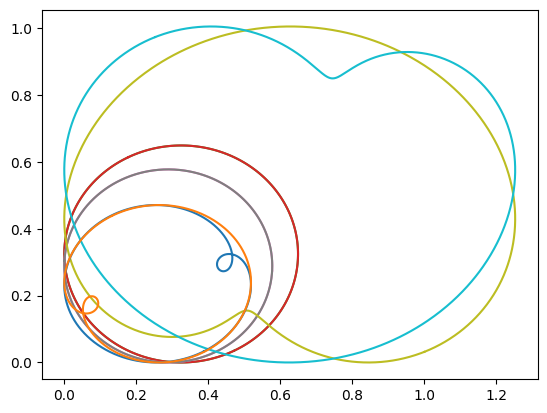

In [14]:
draw_n = 2
for i in range(NODE_COUNT):
    plt.plot(curve[draw_n,i,:,0], curve[draw_n,i,:,1])
    plt.plot(curve_rot[draw_n,i,:,0],curve_rot[draw_n,i,:,1])

In [35]:

"""VALIDATE"""
for b in range(BATCH_SIZE):
    mech = mechanisms_dict[b]
    _, sol_b, _, _ = solve_mechanism(C=mech["C_mat"], x0=mech["X0"],fixed_nodes=mech["fixed_nodes"],motor=mech["motor"],timesteps=TIMESTEPS)
    if sol_b is None:
        assert torch.isnan(sol[b]).sum() > 0
        continue
    sol_b = sol_b[0]
    
    assert torch.allclose(sol_b.float(), sol[b].float(), atol=1e-3)

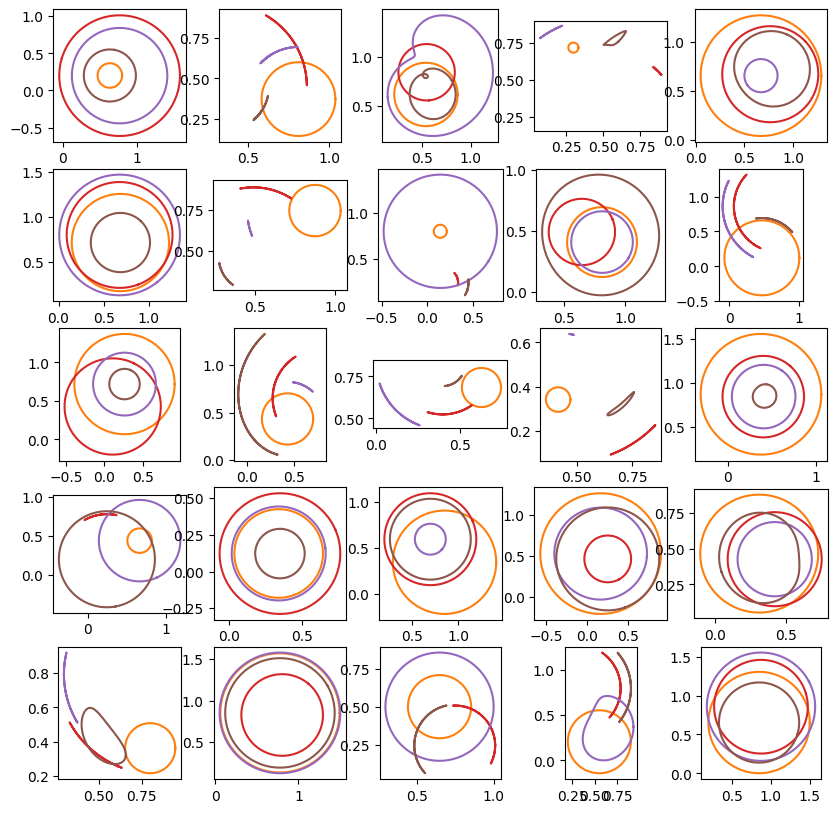

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
plotn = 5
fig, axs = plt.subplots(plotn, plotn, figsize=(10,10))
plt.figure()
for row in range(plotn):
    for col in range(plotn):
        for i in range(NODE_COUNT):
            data = sol[row*plotn+ col]
            axs[row,col].plot(data[i,:,0], data[i,:,1])
            axs[row,col].set_aspect("equal")